# Soil Tutorial

## Introduction

This notebook is an introduction to the soil agent-based social network simulation framework.
In particular, we will focus on a specific use case: studying the propagation of news in a social network.

The steps we will follow are:

* Modelling the behavior of agents
* Running the simulation using different configurations
* Analysing the results of each simulation

But before that, let's import the soil module and networkx.

In [1]:
import soil
import networkx as nx
 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

## Basic concepts

There are three main elements in a soil simulation:
    
* The environment or model. It assigns agents to nodes in the network, and stores the environment parameters (shared state for all agents).
* The network topology. A simulation may use an existing NetworkX topology, or generate one on the fly.
* Agents. There are several types of agents, depending on their behavior and their capabilities. Some examples of built-in types of agents are:
  - Network agents, which are linked to a node in the topology. They have additional methods to access their neighbors.
  - FSM (Finite state machine) agents. Their behavior is defined in terms of states, and an agent will move from one state to another.
  - Evented agents, an actor-based model of agents, which can communicate with one another through message passing.
  - For convenience, a general `soil.Agent` class is provided, which inherits from Network, FSM and Evented at the same time.

Soil provides several abstractions over events to make developing agents easier.
This means you can use events (timeouts, delays) in soil, but for the most part we will assume your models will be step-based o.


## Modeling behaviour

Our first step will be to model how every person in the social network reacts to hearing a piece of disinformation (news).
We will follow a very simple model based on a finite state machine.

A person may be in one of two states: **neutral** (the default state) and **infected**.
A neutral person may hear about a piece of disinformation either on the TV (with probability **prob_tv_spread**) or through their friends.
Once a person has heard the news, they will spread it to their friends (with a probability **prob_neighbor_spread**).
Some users do not have a TV, so they will only be infected by their friends.

The spreading probabilities will change over time due to different factors.
We will represent this variance using an additional agent which will not be a part of the social network.

### Modelling Agents

The following sections will cover the basics of developing agents in SOIL.

For more advanced patterns, please check the **examples** folder in the repository.

#### Basic agents

The most basic agent in Soil is ``soil.BaseAgent``.
These agents implement their behavior by overriding the `step` method, which will be run in every simulation step.
Only one agent will be running at any given time, and it will be doing so until the `step` function returns.

Agents can access their environment through their ``self.model`` attribute.
This is most commonly used to get access to the environment parameters and methods.
Here is a simple example of an agent:


```python
class ExampleAgent(BaseAgent):
    def init(self):
        self.is_infected = False
        self.steps_neutral = 0
    
    def step(self):
        # Implement agent logic
        if self.is_infected:
            ... # Do something, like infecting other agents
            return self.die("No need to do anything else") # Stop forever
        else:
            ... # Do something
            self.steps_neutral += 1
            if self.steps_neutral > self.model.max_steps_neutral:
                self.is_infected = True
```



Any kind of agent behavior can be implemented with this `step` function.
However, it has two main drawbacks: 1) complex behaviors can get difficult both write and understand; 2) these behaviors are not composable.

#### FSM agents

One way to solve both issues is to model agents as **[Finite-state Machines](https://en.wikipedia.org/wiki/Finite-state_machine)** (FSM, for short).
FSM define a series of possible states for the agent, and changes between these states.
These states can be modelled and extended independently.

This is modelled in Soil through the `soil.FSM` class.
Agents that inherit from ``soil.FSM`` do not need to specify a ``step`` method.
Instead, we describe each finite state with a function.
To change to another state, a function may return the new state, or the ``id`` of a state.
If no state is returned, the state remains unchanged.

The current state of the agent can be checked with ``agent.state_id``.
That state id can be used to look for other agents in that specific state.

Our previous example could be expressed like this:

```python
class FSMExample(FSM):

    def init(self):
        self.steps_neutral = 0
    
    @state(default=True)
    def neutral(self):
        ... # Do something
        self.steps_neutral += 1
        if self.steps_neutral > self.model.max_steps_neutral:
            return self.infected  # Change state

    @state
    def infected(self):
        ... # Do something
        return self.die("No need to do anything else")
```

#### Generator-based agents

Another design pattern that can be very useful in some cases is to model each step (or a specific state) using generators (the `yield` keyword).



```python
class GenExample(BaseAgent):
    def step(self):
        for i in range(self.model.max_steps_neutral):
            ... # Do something
            yield  # Signal the scheduler that this step is done for now
        ... # Do something
        return self.die("No need to do anything else")        
```

#### Telling the scheduler when to wake up an agent

By default, every agent will be called in every simulation step, and the time elapsed between two steps is controlled by the `interval` attribute in the environment.

But agents may signal the scheduler when they expect to be called again.
This is especially useful when an agent is going to be dormant for a long time.
To do so, an agent can return (or `yield`) from a `step` or a `state` a value of type `soil.When` (absolute time), `soil.Delta` (relative time) or `soil.Cond`, telling the scheduler when the agent will be ready to run again.
If it returns nothing (i.e., `None`), the agent will be ready to run at the next simulation step.

### Environment agents

Environment agents allow us to control the state of the environment.
In this case, we will use an environment agent to simulate a very viral event.

When the event happens, the agent will modify the probability of spreading the rumor.

In [2]:
import logging

class EventGenerator(soil.BaseAgent):
    level = logging.INFO
    
    def step(self):
        # Do nothing until the time of the event
        yield soil.When(self.model.event_time)
        self.info("TV event happened")
        self.model.prob_tv_spread = 0.5
        self.model.prob_neighbor_spread *= 2
        self.model.prob_neighbor_spread = min(self.model.prob_neighbor_spread, 1)
        yield
        self.model.prob_tv_spread = 0

        while self.alive:
            self.model.prob_neighbor_spread = self.model.prob_neighbor_spread * self.model.neighbor_factor
            if self.model.prob_neighbor_spread < 0.01:
                return self.die("neighbors can no longer spread the rumour")
            yield

### Environment (Model)

Let's define a environment model to test our event generator agent.
This environment will have a single agent (the event generator).
We will also tell the environment to save the value of `prob_tv_spread` after every step:

In [3]:
class NewsEnv(soil.NetworkEnvironment):
    
    prob_tv_spread = 0.1
    prob_neighbor_spread = 0.1
    event_time = 10
    tv_factor = 0.5
    neighbor_factor = 0.9

    
    def init(self):
        self.add_model_reporter("prob_tv_spread")
        self.add_agent(EventGenerator)

Once the environment has been defined, we can run a simulation 

In [4]:
it = NewsEnv.run(iterations=1, dump=False, max_time=14)

it[0].model_df()

NewsEnv:   0%|          | 0/1 [00:00<?, ?configuration/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,step,agent_count,prob_tv_spread
time,,,
0,0,1,0.1
10,1,1,0.1
11,2,1,0.5
12,3,1,0.0
13,4,1,0.0
14,5,1,0.0


As we can see, the event occurred right after `t=10`, so by `t=11` the value of `prob_tv_spread` was already set to `1.0`.

You may notice nothing happened between `t=0` and `t=1`.
That is because there aren't any other agents in the simulation, and our event generator explicitly waited until `t=10`.

### Network agents

In our disinformation scenario, we will model our agents as a FSM with two states: ``neutral`` (default) and ``infected``.

Here's the code:

In [5]:
class NewsSpread(soil.Agent):
    has_tv = False
    infected_by_friends = False
    
    @soil.state(default=True)
    def neutral(self):
        if self.infected_by_friends:
            return self.infected
        if self.has_tv:
            if self.prob(self.model.prob_tv_spread):
                return self.infected
            
    @soil.state
    def infected(self):
        for neighbor in self.iter_neighbors(state_id=self.neutral.id):
            if self.prob(self.model.prob_neighbor_spread):
                neighbor.infected_by_friends = True

We can check that our states are well defined, here:

In [6]:
NewsSpread.states()

['dead', 'neutral', 'infected']

### Environment (Model)

Let's modify our simple simulation.
We will add a network of agents of type NewsSpread.

Only one agent (0) will have a TV (in blue).

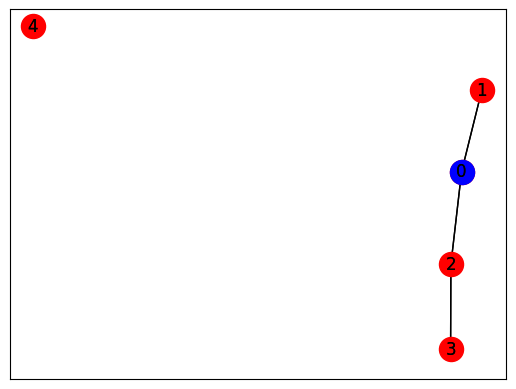

In [7]:
def generate_simple():
    G = nx.Graph()
    G.add_edge(0, 1)
    G.add_edge(0, 2)
    G.add_edge(2, 3)
    G.add_node(4)
    return G

G = generate_simple()
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color='red')
nx.draw_networkx(G, pos, nodelist=[0], node_color='blue')

In [8]:
class NewsEnv(soil.NetworkEnvironment):
    
    prob_tv_spread = 0
    prob_neighbor_spread = 0.1
    event_time = 10
    tv_factor = 0.5
    neighbor_factor = 0.9

    
    def init(self):
        self.add_agent(EventGenerator)
        self.G = generate_simple()
        self.populate_network(NewsSpread)
        self.agent(node_id=0).has_tv = True
        self.add_model_reporter('prob_tv_spread')
        self.add_model_reporter('prob_neighbor_spread')

In [22]:
it = NewsEnv.run(max_time=20)
it[0].model_df()

NewsEnv:   0%|          | 0/1 [00:00<?, ?configuration/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,step,agent_count,prob_tv_spread,prob_neighbor_spread
time,,,,
0,0,6,0.0,0.100000
1,1,6,0.0,0.100000
2,2,6,0.0,0.100000
3,3,6,0.0,0.100000
4,4,6,0.0,0.100000
5,5,6,0.0,0.100000
6,6,6,0.0,0.100000
7,7,6,0.0,0.100000
8,8,6,0.0,0.100000


In this case, notice that the inclusion of other agents (which run every step) means that the simulation did not skip to `t=10`.

Now, let's look at the state of our agents in every step:

No agent dataframe provided. Skipping agent plot.


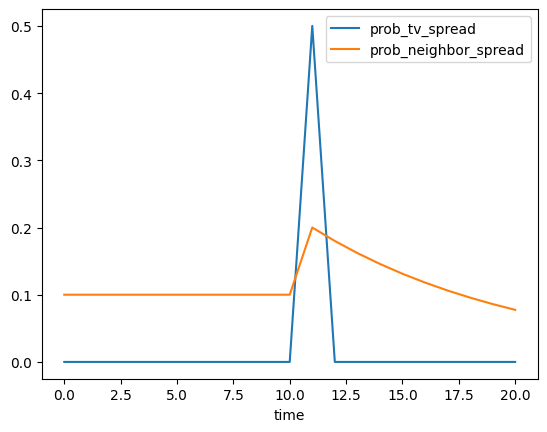

In [23]:
soil.analysis.plot(it[0])

## Running in more scenarios

In real life, you probably want to run several simulations, varying some of the parameters so that you can compare and answer your research questions.

For instance:
    
* Does the outcome depend on the structure of our network? We will use different generation algorithms to compare them (Barabasi-Albert and Erdos-Renyi)
* How does neighbor spreading probability affect my simulation? We will try probability values in the range of [0, 0.4], in intervals of 0.1.

In [11]:
class NewsEnvComplete(soil.Environment):
    prob_tv = 0.05
    prob_tv_spread = 0
    prob_neighbor_spread = 0
    event_time = 10
    tv_factor = 0
    neighbor_factor = 0.5
    generator = "erdos_renyi_graph"
    n = 100

    def init(self):
        self.add_agent(EventGenerator)
        if not self.G:
            opts = {"n": self.n}
            if self.generator == "erdos_renyi_graph":
                opts["p"] = 0.5
            elif self.generator == "barabasi_albert_graph":
                opts["m"] = 4
            self.create_network(generator=self.generator, **opts)

        self.populate_network([NewsSpread,
                               NewsSpread.w(has_tv=True)],
                              [1-self.prob_tv, self.prob_tv])
        self.add_model_reporter('prob_tv_spread')
        self.add_model_reporter('prob_neighbor_spread')
        self.add_agent_reporter('state_id')

Since we do not care about previous results, we will set`overwrite=True`.

In [12]:
s = soil.Simulation(model=NewsEnvComplete, iterations=5, max_time=30, dump=True, overwrite=True)
N = 100
probabilities = [0, 0.25, 0.5, 0.75, 1.0]
generators = ["erdos_renyi_graph", "barabasi_albert_graph"]


it = s.run(name=f"newspread", matrix=dict(n=[N], generator=generators, prob_neighbor_spread=probabilities))

[INFO ][18:00:39] Output directory: /mnt/data/home/j/git/lab.gsi/soil/soil/examples/tutorial/soil_output


newspread:   0%|          | 0/10 [00:00<?, ?configuration/s]

n = 100
generator = erdos_renyi_graph
prob_neighbor_spread = 0


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = erdos_renyi_graph
prob_neighbor_spread = 0.25


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = erdos_renyi_graph
prob_neighbor_spread = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = erdos_renyi_graph
prob_neighbor_spread = 0.75


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = erdos_renyi_graph
prob_neighbor_spread = 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = barabasi_albert_graph
prob_neighbor_spread = 0


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = barabasi_albert_graph
prob_neighbor_spread = 0.25


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = barabasi_albert_graph
prob_neighbor_spread = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = barabasi_albert_graph
prob_neighbor_spread = 0.75


  0%|          | 0/5 [00:00<?, ?it/s]

n = 100
generator = barabasi_albert_graph
prob_neighbor_spread = 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
assert len(it) == len(probabilities) * len(generators) * s.iterations

The results are conveniently stored in sqlite (history of agent and environment state) and the configuration is saved in a YAML file.

You can also export the results to GEXF format (dynamic network) and CSV using .`run(dump=['gexf', 'csv'])` or the command line flags `--graph --csv`.

In [14]:
!tree soil_output
!du -xh soil_output/*

soil_output
└── newspread
    ├── newspread_1681989837.124865.dumped.yml
    ├── newspread_1681990513.1584163.dumped.yml
    ├── newspread_1681990524.5204282.dumped.yml
    ├── newspread_1681990796.858183.dumped.yml
    ├── newspread_1682002299.544348.dumped.yml
    ├── newspread_1682003721.597205.dumped.yml
    ├── newspread_1682003784.1948986.dumped.yml
    ├── newspread_1682003812.4626257.dumped.yml
    ├── newspread_1682004020.182087.dumped.yml
    ├── newspread_1682004044.6837814.dumped.yml
    ├── newspread_1682004398.267355.dumped.yml
    ├── newspread_1682004564.1052232.dumped.yml
    ├── newspread_1682351953.9104202.dumped.yml
    ├── newspread_1682352039.0612123.dumped.yml
    └── newspread.sqlite

1 directory, 15 files
21M	soil_output/newspread


### Analysing the results

#### Loading data

Once the simulations are over, we can use soil to analyse the results.

There are two main ways: directly using the iterations returned by the `run` method, or loading up data from the results database.
This is particularly useful to store data between sessions, and to accumulate results over multiple runs.

The mainThe main method to load data from the database is `read_sql`, which can be used in two ways:

* `analysis.read_sql(<sqlite_file>)` to load all the results from a sqlite database . e.g. `read_sql('my_simulation/file.db.sqlite')`
* `analysis.read_sql(name=<simulation name>)` will look for the default path for a simulation named `<simulation name>`

The result in both cases is a named tuple with four dataframes:

* `configuration`, which contains configuration parameters per simulation
* `parameters`, which shows the parameters used **in every iteration** of every simulation
* `env`, with the data collected from the model in each iteration (as specified in `model_reporters`)
* `agents`, like `env`, but for `agent_reporters`

Let's see it in action by loading the stored results into a pandas dataframe:

In [15]:
res = soil.read_sql(name="newspread", include_agents=True)

### Plotting data

Once we have loaded the results from the file, we can use them just like any other dataframe.

Here is an example of plotting the ratio of infected users in each of our simulations:

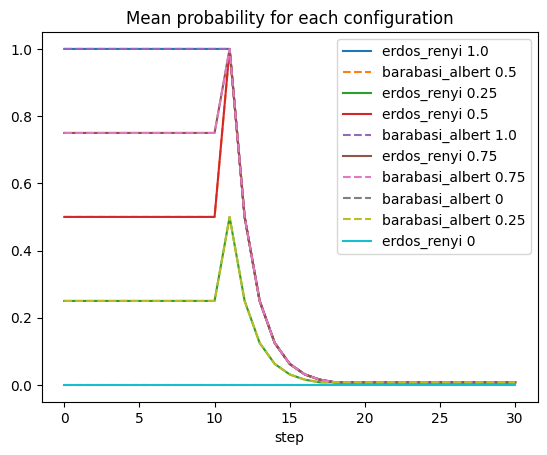

In [16]:
for (g, group) in res.env.dropna().groupby("params_id"):
    params = res.parameters.query(f'params_id == "{g}"').iloc[0]
    title = f"{params.generator.rstrip('_graph')} {params.prob_neighbor_spread}"
    prob = group.groupby(by=["step"]).prob_neighbor_spread.mean()
    line = "-"
    if "barabasi" in params.generator:
        line = "--"
    prob.rename(title).fillna(0).plot(linestyle=line)
plt.title("Mean probability for each configuration")
plt.legend();

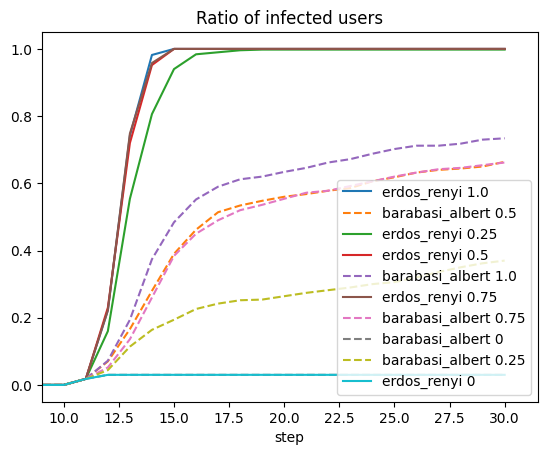

In [17]:
for (g, group) in res.agents.dropna().groupby("params_id"):
    params = res.parameters.query(f'params_id == "{g}"').iloc[0]
    title = f"{params.generator.rstrip('_graph')} {params.prob_neighbor_spread}"
    counts = group.groupby(by=["step", "state_id"]).value_counts().unstack()
    line = "-"
    if "barabasi" in params.generator:
        line = "--"
    (counts.infected/counts.sum(axis=1)).rename(title).fillna(0).plot(linestyle=line)
plt.legend()
plt.xlim([9, None]);
plt.title("Ratio of infected users");

## Data format

### Parameters

The `parameters` dataframe has three keys:

* The identifier of the simulation. This will be shared by all iterations launched in the same run
* The identifier of the parameters used in the simulation. This will be shared by all iterations that have the exact same set of parameters.
* The identifier of the iteration. Each row should have a different iteration identifier

There will be a column per each parameter passed to the environment. In this case, that's three: **generator**, **n** and **prob_neighbor_spread**.

In [18]:
res.parameters.head()

key                                                              generator  \
iteration_id params_id simulation_id                                         
0            39063f8   newspread_1682352039.0612123      erdos_renyi_graph   
             8f26adb   newspread_1682352039.0612123  barabasi_albert_graph   
             92fdcb9   newspread_1682352039.0612123      erdos_renyi_graph   
             cb3dbca   newspread_1682352039.0612123      erdos_renyi_graph   
             d1fe9c1   newspread_1682352039.0612123  barabasi_albert_graph   

key                                                    n prob_neighbor_spread  
iteration_id params_id simulation_id                                           
0            39063f8   newspread_1682352039.0612123  100                  1.0  
             8f26adb   newspread_1682352039.0612123  100                  0.5  
             92fdcb9   newspread_1682352039.0612123  100                 0.25  
             cb3dbca   newspread_1682352039.0612123  100                  0.5  
             d1fe9c1   newspread_1682352039.0612123  100                  1.0

### Configuration

This dataset is indexed by the identifier of the simulation, and there will be a column per each attribute of the simulation.
For instance, there is one for the number of processes used, another one for the path where the results were stored, etc.

In [19]:
res.config.head()

,index,version,source_file,name,description,group,backup,overwrite,dry_run,dump,...,num_processes,exporters,model_reporters,agent_reporters,tables,outdir,exporter_params,level,skip_test,debug
simulation_id,,,,,,,,,,,,,,,,,,,,,
newspread_1682352039.0612123,0,2,None,newspread,,None,False,True,False,True,...,1,[<class 'soil.exporters.default'>],{},{},{},/mnt/data/home/j/git/lab.gsi/soil/soil/example...,{},20,False,False


### Model reporters

The `env` dataframe includes the data collected from the model.
The keys in this case are the same as `parameters`, and an additional one: **step**.

In [20]:
res.env.head()

agent_count  time  \
simulation_id                params_id iteration_id step                      
newspread_1682352039.0612123 ff1d24a   0            0             101     0   
                                                    1             101     1   
                                                    2             101     2   
                                                    3             101     3   
                                                    4             101     4   

                                                          prob_tv_spread  \
simulation_id                params_id iteration_id step                   
newspread_1682352039.0612123 ff1d24a   0            0                0.0   
                                                    1                0.0   
                                                    2                0.0   
                                                    3                0.0   
                                                    4                0.0   

                                                          prob_neighbor_spread  
simulation_id                params_id iteration_id step                        
newspread_1682352039.0612123 ff1d24a   0            0                      0.0  
                                                    1                      0.0  
                                                    2                      0.0  
                                                    3                      0.0  
                                                    4                      0.0

### Agent reporters

This dataframe reflects the data collected for all the agents in the simulation, in every step where data collection was invoked.

The key in this dataframe is similar to the one in the `parameters` dataframe, but there will be two more keys: the `step` and the `agent_id`.
There will be a column per each agent reporter added to the model. In our case, there is only one: `state_id`.

In [21]:
res.agents.head()

state_id
simulation_id                params_id iteration_id step agent_id         
newspread_1682352039.0612123 ff1d24a   0            0    0            None
                                                         1         neutral
                                                         2         neutral
                                                         3         neutral
                                                         4         neutral